<a href="https://colab.research.google.com/github/Chirag314/Monthly-supply-of-houses-in-US/blob/main/Monthly_supply_of_new_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Reference 
1.https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

2.https://www.kaggle.com/code/ashwinshetgaonkar/wind-power-arima

In [1]:
#Import packages
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time
import os

pd.set_option('display.float_format',lambda x: '%.4f' %x)
import seaborn as sns 
sns.set_context('paper',font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.metrics import mean_absolute_percentage_error

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

from IPython.core.display import HTML,display

import matplotlib.pyplot as plt
%matplotlib inline





<code style="background:yellow;color:red">Basic EDA</code>
####1.Check shape of data and other attributes

In [30]:
# read dataset
df=pd.read_csv('MSACSR1.csv',delimiter=',')
row, columns=df.shape[0],df.shape[1]
print(row, columns)

df.head()

712 2


,DATE,MSACSR
0,1963-01-01,4.7000
1,1963-02-01,6.6000
2,1963-03-01,6.4000
3,1963-04-01,5.3000
4,1963-05-01,5.1000


In [37]:
# Convert your daily column from just string to DateTime (skip if already done)
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE',inplace=True)
# Specify datetime frequency
#df = df.asfreq('M')

In [38]:
df.head()

,MSACSR
DATE,
1963-01-01,4.7000
1963-02-01,6.6000
1963-03-01,6.4000
1963-04-01,5.3000
1963-05-01,5.1000


In [39]:
display(HTML(f"<h3>  <b style='color:blue;font-size:22px;'>Inference </b>:<ul><li>There are {row} rows and {columns} columns.</li></ul></h3>"))

In [40]:
# checking for NaN values.
no_of_nan_values=df.isna().sum().sum()
no_of_nan_values

0

In [41]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>There are {no_of_nan_values} NaN values.</li></ul></h3>"))

## **VISUALIZING DATA:**

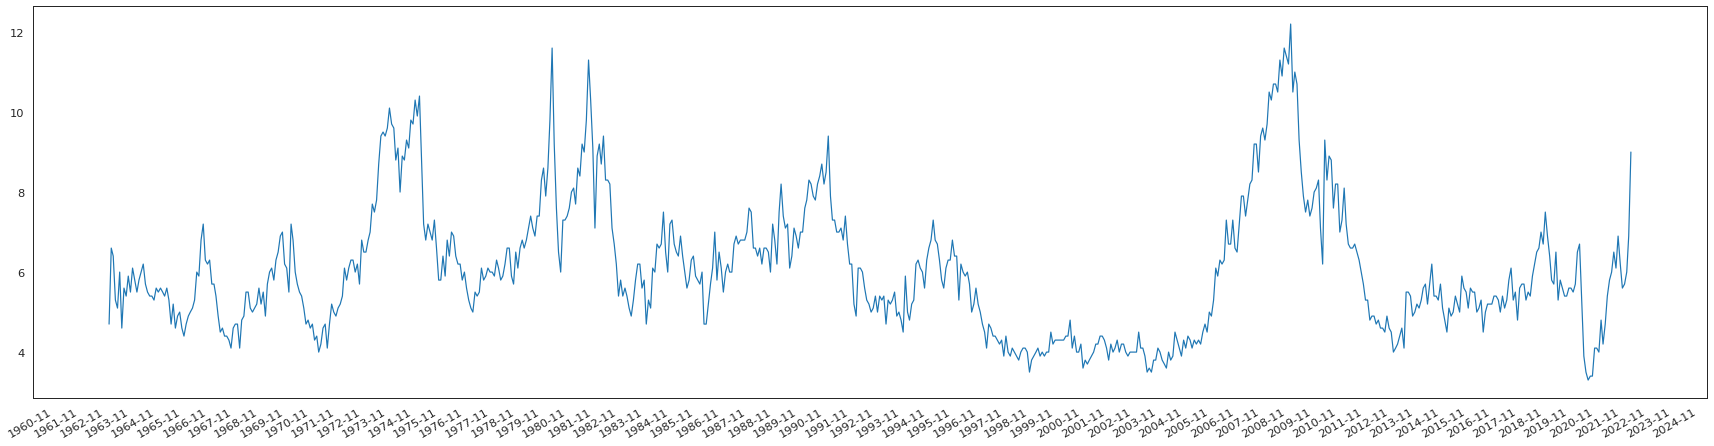

In [44]:
import matplotlib.dates as mdates
#plt.figure(figsize=(30,8))
#sns.lineplot(data=df,x=df.index,y='MSACSR',color='red',lw=2,)

#plt.xticks(rotation=45)

#plt.ylabel("Ratio of new house for sale/sold")
#plt.title('Monthly supply of new houses in United States')

fig, ax = plt.subplots(figsize=(30, 8))

monthly_locator = mdates.MonthLocator()
year_locator = mdates.MonthLocator(interval=12)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(df.index, df.MSACSR)

fig.autofmt_xdate()

<code style="background:ORANGE;color:BLUE">CHECK SEASONALITY AND TREND </code>

In [45]:
# Check stationarity of the data
def adf_test(timeseries):
    print("Results of Augmented Dickey-fuller test")
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    print(dfoutput)


In [46]:
df['first_diff']=df['MSACSR'].diff(periods=1)

In [47]:
df.head()

,MSACSR,first_diff
DATE,,
1963-01-01,4.7000,NaN
1963-02-01,6.6000,1.9000
1963-03-01,6.4000,-0.2000
1963-04-01,5.3000,-1.1000
1963-05-01,5.1000,-0.2000


In [48]:
adf_test(df.first_diff.dropna())

Results of Augmented Dickey-fuller test
Test Statistic                 -5.7896
p-value                         0.0000
#lags used                     19.0000
number of observations used   691.0000
critical value (1%)            -3.4398
critical value (5%)            -2.8657
critical value (10%)           -2.5690
dtype: float64


####Since the p-value < 0.05 we can say that time-series is stationary.

In [49]:

# Check KPSS test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', lags=None)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [50]:
kpss_test(df.first_diff.dropna())

Results of KPSS Test:
Test Statistic           0.0419
p-value                  0.1000
#Lags Used              20.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


####Since the p-value > 0.05 we can say that time-series is stationary.

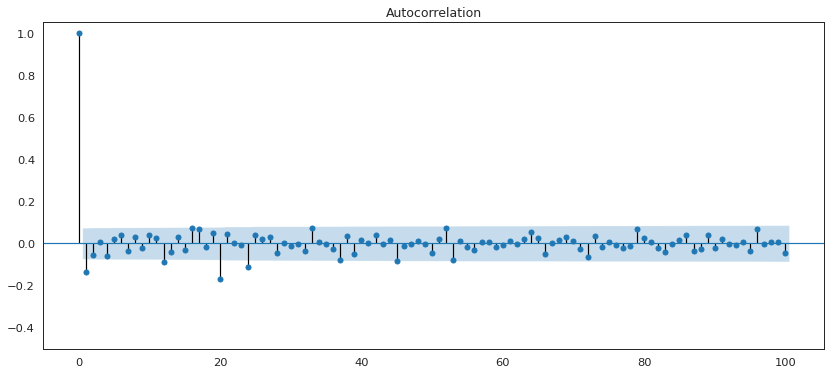

In [51]:
# Check ACF(Autocorrelation)
fig,ax=plt.subplots(figsize=(14,6))
plot_acf(df.first_diff.dropna(),ax=ax,lags=100);
plt.ylim([-0.5,1.05]);

####Since the Series passed in both of the tests for Stationarity and the series shows low auto-correlations the series is now Stationary.

In [53]:
# Splitting train/val/test dataset
num_train_samples=360  # Almost half of the samplesfor traing and remaining half equally between val and test
num_val_samples=int((len(df)-num_train_samples)/2)
num_test_samples=num_val_samples
print("Number of training samples :",num_train_samples)
print("Number of validation samples :", num_val_samples)
print("Number of test samples  :", num_test_samples)

Number of training samples : 360
Number of validation samples : 176
Number of test samples  : 176


###Preparing the data
####1.Normalizing the data

In [54]:
mean=df[:num_train_samples].mean(axis=0)
df-=mean
std=df[:num_test_samples].std(axis=0)
df/=std

#### Now lets create a Dataset object that yields batches of data from the past 12 months with the target MSACSR value for next month. We should generate the samples on the fly rather than allocating memory for each sample. We will use built in dataset utility in Keras called timeseries_dataset_from_array()
- We have to write three datasets one for trainaing, onve for validation and one for testing


In [77]:
train_dataset=tf.keras.utils.timeseries_dataset_from_array(
    df.MSACSR[:-12],
    targets=df.MSACSR[12:],
    sampling_rate=2,
    sequence_length=12,
    shuffle=True,
    batch_size=1,
    start_index=0,
    end_index=num_train_samples
)
val_dataset=tf.keras.utils.timeseries_dataset_from_array(
    df.MSACSR[:-12],
    targets=df.MSACSR[12:],
    sampling_rate=1,
    sequence_length=12,
    shuffle=True,
    batch_size=1,
    start_index=num_train_samples,
    end_index=num_train_samples+num_val_samples
)
test_dataset=tf.keras.utils.timeseries_dataset_from_array(
    df.MSACSR[:-12],
    targets=df.MSACSR[12:],
    sampling_rate=1,
    sequence_length=12,
    shuffle=True,
    batch_size=1,
    start_index=num_train_samples+num_val_samples
  )


In [78]:
for samples, targets in train_dataset:
  print("Samples shape :",samples.shape)
  print("Target shape: ",targets.shape)
  print(samples[-1])
  print(targets[-1])
  print(len(train_dataset))
  break

Samples shape : (1, 12)
Target shape:  (1,)
tf.Tensor(
[-0.45526819 -0.45526819 -0.18165125 -0.66048089 -0.72888513 -0.59207666
 -0.59207666 -0.72888513 -0.79728936 -0.8656936  -1.07090631 -1.27611901], shape=(12,), dtype=float64)
tf.Tensor(-0.5920766590045233, shape=(), dtype=float64)
337


####SET A COMMON SENSE NON-MACHINE LEARNING BASELINE
#####-Here the time series can safely be assumed as continuous( data values next month are likely to be close to data value of current month). Thus a common sence approach is to always predict that the MSACSR value 1 month from now will be equal to the value of this month. Then find MAE as a baseline matric.

In [79]:
def evaluate_naive_method(dataset):
  total_abs_err=0.
  samples_seen=0
  for samples, targets in dataset:
    preds=samples[:,-1]*std[1]+mean[1] #Un-normalise the data
    total_abs_err+=np.sum(np.abs(preds-targets))
    samples_seen+=samples.shape[0]
  return total_abs_err/samples_seen


print(f"Validation MAE :{evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE : {evaluate_naive_method(test_dataset):.2f}")


Validation MAE :0.63
Test MAE : 0.51


####The common sense baseline achieves validation MAE of 0.63 and test MAE of 0.51 . So if you always assume that the MASCSR value after a month will be same as this month, you will be off by 0.5 on average. Its not bad as average ratio is about 5 . 

#####Lets try basic machine learning model. Its useful to try simple cheap machinge learning model before looking into more complicated models such as RNN, LSTMs.This is to make sure any further complexity at the problem delivers real benefits.
Here is model 1


In [80]:
inputs=keras.Input(shape=(12,df.shape[-1]))
inputs

<KerasTensor: shape=(None, 12, 2) dtype=float32 (created by layer 'input_4')>

In [81]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [83]:
inputs=tf.keras.Input(shape=(12))
x=layers.Flatten()(inputs)
x=layers.Dense(16,activation='relu')(x)
outputs=layers.Dense(1)(x)
model=tf.keras.Model(inputs,outputs)

callbacks=[
           tf.keras.callbacks.ModelCheckpoint("best_dense.keras",save_best_only=True)
           ]

model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
model.summary()
history=model.fit(train_dataset,
                  epochs=10,
                  validation_data=val_dataset,
                  callbacks=callbacks)

model=tf.keras.models.load_model("best_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 12)]              0         
                                                                 
 flatten_2 (Flatten)         (None, 12)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                208       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
337/337 [==============================] - 1s 3ms/step - loss: 0.3380 - mae: 0.4309 - val_loss: 0.1697 - val_mae: 0.3203
Epoch 2/10
337/337 [==============================] - 1s 3ms/